<a href="https://colab.research.google.com/github/ykim68ncstate/ST-554-Project1/blob/main/Task2/Project_1_Task_2_David_Pressley.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Project 1 - On Field Calibration of Electronic Nose for Benzene Estimation

## Introduction
Low cost gas sensors used in urban air pollution monitoring facet two key problems:


1.   *Specificity* Available sensors are unable to distinguish between gases well
2.   *Drift*: Solid-state sensors measurements drift making their quantitative measurements unreliable over time, due to:
*   intrinsic physical and chemical properties
*   environmental temperature fluctuations
*   exposure to the environment
*   oxidation of the sensor surface

The manufacturer specifies less than 2% drift per 6 months (DeVito, 2008)

## Background
This dataset comes from the UC Irvine Machine Learning repository and contains the reponses of a gas multisensor device deployed in a field in a polluted area in an Italian city. Data were captured from March 2004 to February 2005 (one year), and represent the longest freely available recordings of air quality sensor device measurements.

### Dataset Characteristics

**Collection Context**:
- **Location**: Road-level sensor in a significantly polluted urban area in Italy
- **Duration**: March 2004 to February 2005 (12 months)
- **Instances**: 9,358 hourly averaged observations
- **Device**: Air Quality Chemical Multisensor Device with 5 metal oxide sensors

**Variable Types**:

| Type | Variables | Source |
|------|-----------|--------|
| Ground truth (GT) | CO(GT), NMHC(GT), C6H6(GT), NOx(GT), NO2(GT) | Co-located certified reference analyzer |
| Sensor responses | PT08.S1(CO), PT08.S2(NMHC), PT08.S3(NOx), PT08.S4(NO2), PT08.S5(O3) | Metal oxide sensor array |
| Environmental | T (temperature), RH (relative humidity), AH (absolute humidity) | Weather measurements |

**Data Quality Issues**:
- **Missing values**: Tagged with `-200` (not NaN). These will be replaced with NaN but not removed for intermediate dataset creation to retain complete integrity and veracity of the dataset.
- **Cross-sensitivities**: Sensors respond to multiple gases, not just their target analyte
- **Concept drift**: Underlying pollutant mixture composition changes seasonally (e.g., winter heating increases NOx)
- **Sensor drift**: Baseline resistance changes over the 12-month deployment period

### EDA Analysis Plan

**Univariate summary of C6H6(GT)**
- .describe(), histogram, box plot. Document skewness, range, outliers.
**Correlation investigation**
- .corr() of variables (benzene + 5 non-GT sensors + 3 weather). Discuss which variables are strongly/weakly correlated with benzene.
**Numeric summaries at different levels**
- bin (e.g. temperature into quartiles using pd.qcut(), or a sensor variable)
- show benzene summaries within those groups via .groupby()
**Bivariate plots**
- Scatter plots of benzene against key sensors and weather variables. Use a loop or plt.subplots() to avoid repeating code (GPP/DRY). Discuss what the relationships look like
**Temporal analysis**
- include both "over time" and "ignoring time."
- For over time: line plot of benzene over date
    - create categorical and datetimevalues
- For ignoring time: see scatter/correlation work.
     - at minimum get a time series line plot in.

**Usage Restrictions**: Research purposes only; commercial use fully excluded. Citation of De Vito et al., Sens. And Act. B, Vol. 129, 2, 2008 required.




## Task 2 - Exploratory Data Analysis

### Data Import and Description

In [194]:
# import Colab base imports
from ucimlrepo import fetch_ucirepo
from pprint import pprint
from IPython.display import HTML, display, Markdown
from google.colab import data_table
import pandas as pd
import numpy as np
from datetime import date, datetime
import matplotlib.pyplot as plt

# import ucimlrepo
try:
    import ucimlrepo
    print(f"{datetime.today()}: ucimlrepo is already installed.")
except ImportError:
    print(f"{datetime.today()}: ucimlrepo not found. Installing now...")
    !pip install ucimlrepo -q
    print(f"{datetime.today()}: ucimlrepo installed.")



# load pandas as data table for viewing pleasure
data_table.enable_dataframe_formatter()

# fetch dataset
air_quality_raw = fetch_ucirepo(id=360)

#check the type of each value in the top-level keys
print("Types of top-level values:")
for key in air_quality_raw.keys():
    # get object type, then access its __name__
    print(f"  {key}: {type(air_quality_raw[key]).__name__}")

# Step 2: 'data' is source data. Get keys
if hasattr(air_quality_raw['data'], 'keys'):
    display(Markdown(f"### Keys inside 'data': `{air_quality_raw['data'].keys()}`"))

# convert raw data dictionaries to dataframes.
# ML convention is to store independent vars as features, and any output vars as targets. Targets is empty.
raw_features = air_quality_raw.data.features
display(Markdown(f"### Source (Raw) DataFrame is: `raw_features`   \n \tData Type: {type(raw_features).__name__}.  Use as baseline dataset for subsequent analysis \n\n"))


# describe data
# type is dict <class 'ucimlrepo.dotdict.dotdict'>, so get keys
# print(f"Raw Data Type: {type(air_quality_raw)}")

#keys
raw_keys = [key for key in air_quality_raw.keys()]
display(Markdown(f"### Raw Data Dictionary Keys: {raw_keys}"))

#get variables
# variable information
# Select only the columns 'name', 'type', 'units', 'description'
vars_summary = air_quality_raw.variables[['name', 'type', 'units', 'description']]

# convert dtypes Series to a DataFrame and rename columns
# reset_index creates a column named `index`, and is renamed to `name` for merging below
vars_dtypes = air_quality_raw.data.features.dtypes.reset_index()
vars_dtypes.columns = ['name', 'dtype']

# create variable summary for reference
vars_summary = pd.merge(vars_summary, vars_dtypes, on='name', how='left')
vars_summary = vars_summary[['name', 'type', 'dtype', 'units', 'description']]

# set index to 1 for quick reference of variable count
vars_summary.index += 1
# display(Markdown(vars_summary.to_markdown(index=True)))

# copy these to a Text cell for reference
# get var name metadata
# print((vars_summary.to_markdown(index=True)))
display(Markdown(f"### Raw Dataset Variable Metadata: \n"))
display(vars_summary)

# get data head
# display(Markdown(f"##  Data Head"))
display(Markdown(f"### Raw Dataset Head: \n"))
display((air_quality_raw.data.features.head()))

2026-02-20 05:39:00.635593: ucimlrepo is already installed.
Types of top-level values:
  data: dotdict
  metadata: dotdict
  variables: DataFrame


### Keys inside 'data': `dict_keys(['ids', 'features', 'targets', 'original', 'headers'])`

### Source (Raw) DataFrame is: `raw_features`   
 	Data Type: DataFrame.  Use as baseline dataset for subsequent analysis 



### Raw Data Dictionary Keys: ['data', 'metadata', 'variables']

### Raw Dataset Variable Metadata: 


,name,type,dtype,units,description
1,Date,Date,object,None,None
2,Time,Categorical,object,None,None
3,CO(GT),Integer,float64,mg/m^3,True hourly averaged concentration CO in mg/m^...
4,PT08.S1(CO),Categorical,int64,None,hourly averaged sensor response (nominally CO...
5,NMHC(GT),Integer,int64,microg/m^3,True hourly averaged overall Non Metanic Hydro...
6,C6H6(GT),Continuous,float64,microg/m^3,True hourly averaged Benzene concentration in...
7,PT08.S2(NMHC),Categorical,int64,None,hourly averaged sensor response (nominally NMH...
8,NOx(GT),Integer,int64,ppb,True hourly averaged NOx concentration in ppb...
9,PT08.S3(NOx),Categorical,int64,None,hourly averaged sensor response (nominally NOx...
10,NO2(GT),Integer,int64,microg/m^3,True hourly averaged NO2 concentration in micr...


### Raw Dataset Head: 


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
0,3/10/2004,18:00:00,2.6,1360,150,11.9,1046,166,1056,113,1692,1268,13.6,48.9,0.7578
1,3/10/2004,19:00:00,2.0,1292,112,9.4,955,103,1174,92,1559,972,13.3,47.7,0.7255
2,3/10/2004,20:00:00,2.2,1402,88,9.0,939,131,1140,114,1555,1074,11.9,54.0,0.7502
3,3/10/2004,21:00:00,2.2,1376,80,9.2,948,172,1092,122,1584,1203,11.0,60.0,0.7867
4,3/10/2004,22:00:00,1.6,1272,51,6.5,836,131,1205,116,1490,1110,11.2,59.6,0.7888


## Raw Dataset Variable Metadata
|    | name          | type        | dtype   | units      | description                                                                                            |
|---:|:--------------|:------------|:--------|:-----------|:-------------------------------------------------------------------------------------------------------|
|  1 | Date          | Date        | object  |            |                                                                                                        |
|  2 | Time          | Categorical | object  |            |                                                                                                        |
|  3 | CO(GT)        | Integer     | float64 | mg/m^3     | True hourly averaged concentration CO in mg/m^3  (reference analyzer)                                  |
|  4 | PT08.S1(CO)   | Categorical | int64   |            | hourly averaged sensor response (nominally  CO targeted)                                               |
|  5 | NMHC(GT)      | Integer     | int64   | microg/m^3 | True hourly averaged overall Non Metanic HydroCarbons concentration in microg/m^3 (reference analyzer) |
|  6 | C6H6(GT)      | Continuous  | float64 | microg/m^3 | True hourly averaged Benzene concentration  in microg/m^3 (reference analyzer)                         |
|  7 | PT08.S2(NMHC) | Categorical | int64   |            | hourly averaged sensor response (nominally NMHC targeted)                                              |
|  8 | NOx(GT)       | Integer     | int64   | ppb        | True hourly averaged NOx concentration  in ppb (reference analyzer)                                    |
|  9 | PT08.S3(NOx)  | Categorical | int64   |            | hourly averaged sensor response (nominally NOx targeted)                                               |
| 10 | NO2(GT)       | Integer     | int64   | microg/m^3 | True hourly averaged NO2 concentration in microg/m^3 (reference analyzer)                              |
| 11 | PT08.S4(NO2)  | Categorical | int64   |            | hourly averaged sensor response (nominally NO2 targeted)                                               |
| 12 | PT08.S5(O3)   | Categorical | int64   |            | hourly averaged sensor response (nominally O3 targeted)                                                |
| 13 | T             | Continuous  | float64 | °C         | Temperature                                                                                            |
| 14 | RH            | Continuous  | float64 | %          | Relative Humidity                                                                                      |
| 15 | AH            | Continuous  | float64 |            | Absolute Humidity                                                                                      |



## Raw Dataset Head
| Date      | Time     |   CO(GT) |   PT08.S1(CO) |   NMHC(GT) |   C6H6(GT) |   PT08.S2(NMHC) |   NOx(GT) |   PT08.S3(NOx) |   NO2(GT) |   PT08.S4(NO2) |   PT08.S5(O3) |    T |   RH |     AH |
|:----------|:---------|---------:|--------------:|-----------:|-----------:|----------------:|----------:|---------------:|----------:|---------------:|--------------:|-----:|-----:|-------:|
| 3/10/2004 | 18:00:00 |      2.6 |          1360 |        150 |       11.9 |            1046 |       166 |           1056 |       113 |           1692 |          1268 | 13.6 | 48.9 | 0.7578 |
| 3/10/2004 | 19:00:00 |      2   |          1292 |        112 |        9.4 |             955 |       103 |           1174 |        92 |           1559 |           972 | 13.3 | 47.7 | 0.7255 |
| 3/10/2004 | 20:00:00 |      2.2 |          1402 |         88 |        9   |             939 |       131 |           1140 |       114 |           1555 |          1074 | 11.9 | 54   | 0.7502 |
| 3/10/2004 | 21:00:00 |      2.2 |          1376 |         80 |        9.2 |             948 |       172 |           1092 |       122 |           1584 |          1203 | 11   | 60   | 0.7867 |
| 3/10/2004 | 22:00:00 |      1.6 |          1272 |         51 |        6.5 |             836 |       131 |           1205 |       116 |           1490 |          1110 | 11.2 | 59.6 | 0.7888 |


## Data Cleaning
Data cleaning will be performed on the full dataset before narrowing down features, so that it will be easy to include other Ground Truth sensor variables if needed in the `raw_features` dataset

### Missing values Analysis

#### Handling Missing Values

Based on UCIML repo information, sensor values of `-200` are invalid. We will replace the `-200` placeholder values with `NaN` to properly handle missing data.

In [195]:
# create a new dataframe for feature manipulation
features_clean_df = raw_features.copy()

# Missing values analysis before replacement
# replace -200 with NaN across the features_clean_df DataFrame
display(Markdown(f"### Action: Replacing -200 values with NaN in features_clean_df DataFrame"))
features_clean_df.replace(-200, np.nan, inplace=True);


# Missing values analysis after replacement
# Calculate counts and percentages
column_metadata = pd.DataFrame({
    'name': features_clean_df.columns,
    'total_count': len(features_clean_df),
    'ok_sensor_count': features_clean_df.count(),
    'bad_sensor_count': features_clean_df.isnull().sum(),
    'missing_percentage': (features_clean_df.isnull().sum() / len(features_clean_df)) * 100
})

# Select and reorder columns
column_metadata = column_metadata[['name', 'bad_sensor_count', 'ok_sensor_count', 'missing_percentage', 'total_count']]
display(Markdown((f"### DataFrame containing column metadata after replacing -200 values with NaN:")))
display(Markdown(column_metadata.to_markdown(index=False)))

### Action: Replacing -200 values with NaN in features_clean_df DataFrame

### DataFrame containing column metadata after replacing -200 values with NaN:

| name          |   bad_sensor_count |   ok_sensor_count |   missing_percentage |   total_count |
|:--------------|-------------------:|------------------:|---------------------:|--------------:|
| Date          |                  0 |              9357 |              0       |          9357 |
| Time          |                  0 |              9357 |              0       |          9357 |
| CO(GT)        |               1683 |              7674 |             17.9865  |          9357 |
| PT08.S1(CO)   |                366 |              8991 |              3.91151 |          9357 |
| NMHC(GT)      |               8443 |               914 |             90.2319  |          9357 |
| C6H6(GT)      |                366 |              8991 |              3.91151 |          9357 |
| PT08.S2(NMHC) |                366 |              8991 |              3.91151 |          9357 |
| NOx(GT)       |               1639 |              7718 |             17.5163  |          9357 |
| PT08.S3(NOx)  |                366 |              8991 |              3.91151 |          9357 |
| NO2(GT)       |               1642 |              7715 |             17.5484  |          9357 |
| PT08.S4(NO2)  |                366 |              8991 |              3.91151 |          9357 |
| PT08.S5(O3)   |                366 |              8991 |              3.91151 |          9357 |
| T             |                366 |              8991 |              3.91151 |          9357 |
| RH            |                366 |              8991 |              3.91151 |          9357 |
| AH            |                366 |              8991 |              3.91151 |          9357 |

### Date and Time Transformation

The `Date` and `Time` columns are stored as strings. Combining them into a single `datetime` column and setting it as the index enables more efficient pandas time series operations like `.resample()`. Original `Date` and `Time` columns in the DataFrame are kept for reference.

We will also verify that each datetime provides uniqueness to the record.

In [196]:
# combine Date and Time into a datetime column
features_clean_df["datetime"] = pd.to_datetime(
    features_clean_df["Date"] + " " + features_clean_df["Time"],
    format="%m/%d/%Y %H:%M:%S"
)

# set as index and drop original string columns
features_clean_df = features_clean_df.set_index("datetime")
# check dtype of the index
print(f"Datetime index dtype: {features_clean_df.index.dtype}")


if len(pd.unique(features_clean_df.index)) == len(pd.unique(features_clean_df.index)):
    print(f"Index contains unique values: \n index: {len(pd.unique(features_clean_df.index))} \n records:{len(features_clean_df)} ")
else:
    print("Index contains duplicate values")

print(f"Date range: {features_clean_df.index.min()} to {features_clean_df.index.max()}")
features_clean_df.head()

Datetime index dtype: datetime64[ns]
Index contains unique values: 
 index: 9357 
 records:9357 
Date range: 2004-03-10 18:00:00 to 2005-04-04 14:00:00


,Date,Time,CO(GT),PT08.S1(CO),NMHC(GT),C6H6(GT),PT08.S2(NMHC),NOx(GT),PT08.S3(NOx),NO2(GT),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,,,,,,,
2004-03-10 18:00:00,3/10/2004,18:00:00,2.6,1360.0,150.0,11.9,1046.0,166.0,1056.0,113.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,3/10/2004,19:00:00,2.0,1292.0,112.0,9.4,955.0,103.0,1174.0,92.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,3/10/2004,20:00:00,2.2,1402.0,88.0,9.0,939.0,131.0,1140.0,114.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,3/10/2004,21:00:00,2.2,1376.0,80.0,9.2,948.0,172.0,1092.0,122.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,3/10/2004,22:00:00,1.6,1272.0,51.0,6.5,836.0,131.0,1205.0,116.0,1490.0,1110.0,11.2,59.6,0.7888


### Data Subsetting

Per the project requirements, we will include:
- Unique key / Index variable:
    - `datetime`: contains one record per hour
- Timing variables:
    - `Date`
    - `Time`
- **Response variable**: `C6H6(GT)` (benzene GT: Ground Truth, microg/m^3)
- **Sensor variables**: `PT08.S1(CO)`, `PT08.S2(NMHC)`, `PT08.S3(NOx)`, `PT08.S4(NO2)`, `PT08.S5(O3)`
- **Weather variables**: `T` (temperature), `RH` (relative humidity), `AH` (absolute humidity)

Exclude the other ground truth columns (`CO(GT)`, `NMHC(GT)`, `NOx(GT)`, `NO2(GT)`) per requirements

In [197]:
keep = ["C6H6(GT)",
        "PT08.S1(CO)",
        "PT08.S2(NMHC)",
        "PT08.S3(NOx)",
        "PT08.S4(NO2)",
        "PT08.S5(O3)",
        "T",
        "RH",
        "AH"]

benzene_analysis_df = features_clean_df[keep].copy()
print((f"Subset shape: {benzene_analysis_df.shape}"))
print((f"Columns: {benzene_analysis_df.columns}"))

zero_rows = benzene_analysis_df[benzene_analysis_df['C6H6(GT)'] == 0]
print(f"Count of rows with C6H6(GT) == 0: {len(zero_rows)}")

# check for NaN values using .isnull() and .any()
# This will return True if there is at least one NaN value in the 'C6H6(GT)' column.
nan_rows = benzene_analysis_df[benzene_analysis_df['C6H6(GT)'].isna()]
print(f"Count of NaN values in C6H6(GT) column: {len(nan_rows)}")

display(benzene_analysis_df.head())

Subset shape: (9357, 9)
Columns: Index(['C6H6(GT)', 'PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)',
       'PT08.S4(NO2)', 'PT08.S5(O3)', 'T', 'RH', 'AH'],
      dtype='object')
Count of rows with C6H6(GT) == 0: 0
Count of NaN values in C6H6(GT) column: 366


,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,
2004-03-10 18:00:00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,9.4,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,9.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,9.2,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,6.5,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


### Dropping rows with Missing Benzene

In [198]:
n_before = len(benzene_analysis_df)
print(f"Rows before: {n_before}")
benzene_analysis_df = benzene_analysis_df.dropna(subset=['C6H6(GT)'])
n_after = len(benzene_analysis_df)
print(f"Rows after: {n_after}")
print(f"Rows dropped: {n_before - n_after}")

Rows before: 9357
Rows after: 8991
Rows dropped: 366


### Data Grouping References
A little bit of housecleaning since the variables are challenging to type
We will create a named variable grouping for easy reference in subsequent DataFrame manipulations, similar to ENVIRONMENT_VARIABLES

- `benzene_col` = `["C6H6(GT)"]`
- `sensor_cols` = `["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)", "PT08.S4(NO2)", "PT08.S5(O3)"]`
- `weather_cols` = `["T", "RH", "AH"]`

In [199]:
target_col = "C6H6(GT)"
sensor_cols = ["PT08.S1(CO)", "PT08.S2(NMHC)", "PT08.S3(NOx)",
               "PT08.S4(NO2)", "PT08.S5(O3)"]
weather_cols = ["T", "RH", "AH"]

print(f"Target Column: {target_col}")
print(f"Sensor Columns: {[x for x in sensor_cols]}")
print(f"Weather Columns: {[x for x in weather_cols]}")

Target Column: C6H6(GT)
Sensor Columns: ['PT08.S1(CO)', 'PT08.S2(NMHC)', 'PT08.S3(NOx)', 'PT08.S4(NO2)', 'PT08.S5(O3)']
Weather Columns: ['T', 'RH', 'AH']


### Post Cleaning Summary

The analysis dataset `benzene_analysis_df` contains hourly observations spanning March 2004 to February 2005, with 9 numeric variables: benzene concentration, five sensor responses, and three weather measurements.

**DataFrame summary:**
- `raw_features` : original as-fetched, never modified
- `features_clean_df` : working copy with NaN replacement and datetime index
- `benzene_analysis_df` : final analysis subset(9 columns, no missing benzene: removed 366 rows of NaN benzene values)

In [200]:
print(benzene_analysis_df.info())
display(benzene_analysis_df.head())


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8991 entries, 2004-03-10 18:00:00 to 2005-04-04 14:00:00
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   C6H6(GT)       8991 non-null   float64
 1   PT08.S1(CO)    8991 non-null   float64
 2   PT08.S2(NMHC)  8991 non-null   float64
 3   PT08.S3(NOx)   8991 non-null   float64
 4   PT08.S4(NO2)   8991 non-null   float64
 5   PT08.S5(O3)    8991 non-null   float64
 6   T              8991 non-null   float64
 7   RH             8991 non-null   float64
 8   AH             8991 non-null   float64
dtypes: float64(9)
memory usage: 702.4 KB
None


,C6H6(GT),PT08.S1(CO),PT08.S2(NMHC),PT08.S3(NOx),PT08.S4(NO2),PT08.S5(O3),T,RH,AH
datetime,,,,,,,,,
2004-03-10 18:00:00,11.9,1360.0,1046.0,1056.0,1692.0,1268.0,13.6,48.9,0.7578
2004-03-10 19:00:00,9.4,1292.0,955.0,1174.0,1559.0,972.0,13.3,47.7,0.7255
2004-03-10 20:00:00,9.0,1402.0,939.0,1140.0,1555.0,1074.0,11.9,54.0,0.7502
2004-03-10 21:00:00,9.2,1376.0,948.0,1092.0,1584.0,1203.0,11.0,60.0,0.7867
2004-03-10 22:00:00,6.5,1272.0,836.0,1205.0,1490.0,1110.0,11.2,59.6,0.7888


---
## Section 2: Univariate Analysis of Benzene Concentration

Before examining relationships between variables, we need to understand the distribution of our primary variable of interest: `C6H6(GT)`, the ground truth benzene concentration measured in micrograms per cubic meter (microg/m^3).

In [201]:

print("Descriptive Statistics for Benzene:")
print(benzene_analysis_df[target_col].describe())

print(f"\nSkewness: {benzene_analysis_df[target_col].skew().round(3)}")
print(f"\nKurtosis: {benzene_analysis_df[target_col].kurtosis().round(3)}")


Descriptive Statistics for Benzene:
count    8991.000000
mean       10.083105
std         7.449820
min         0.100000
25%         4.400000
50%         8.200000
75%        14.000000
max        63.700000
Name: C6H6(GT), dtype: float64

Skewness: 1.362

Kurtosis: 2.489


Discussion: The mean benzene concentration is higher than the median, which along with the positive skewness value confirms a right-skewed distribution, consistent with what we might expect from pollution events. Most readings are moderate, but sometimes move higher due to weather events, higher seasonal values, etc.


### Benzene Histogram

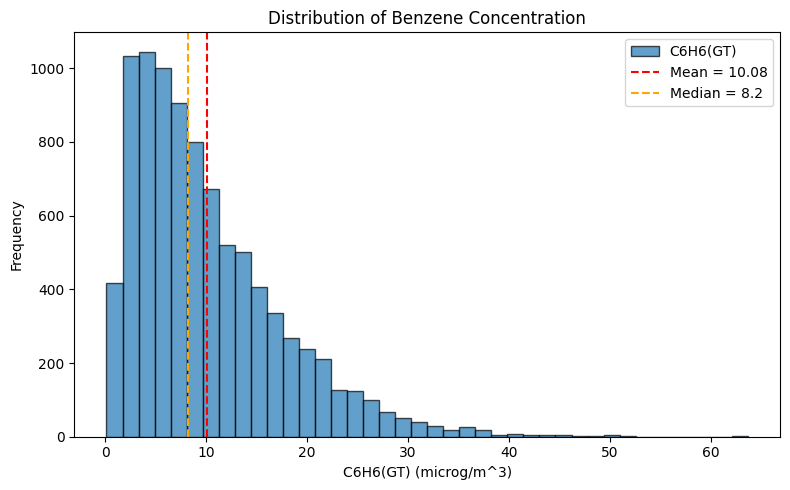

In [209]:
# histogram of benzene concentration
plt.subplots(figsize=(8, 5))
benzene_analysis_df[target_col].plot.hist(bins=40, edgecolor="black", alpha=0.7)
plt.axvline(benzene_analysis_df[target_col].mean(), color="red", linestyle="--",
            label=f"Mean = {round(benzene_analysis_df[target_col].mean(), 2)}")
plt.axvline(benzene_analysis_df[target_col].median(), color="orange", linestyle="--",
            label=f"Median = {round(benzene_analysis_df[target_col].median(), 2)}")
plt.xlabel("C6H6(GT) (microg/m^3)")
plt.ylabel("Frequency")
plt.title("Distribution of Benzene Concentration")
plt.legend()
plt.tight_layout()
plt.show()

**Discussion:** The histogram confirms the right-skewed shape. Most benzene readings are clustered below 15 microg/m^3, with a long tail extending to higher values. The red dashed line (mean) sits to the right of the orange dashed line (median), visually confirming the positive right skew.

Benzene Boxplot

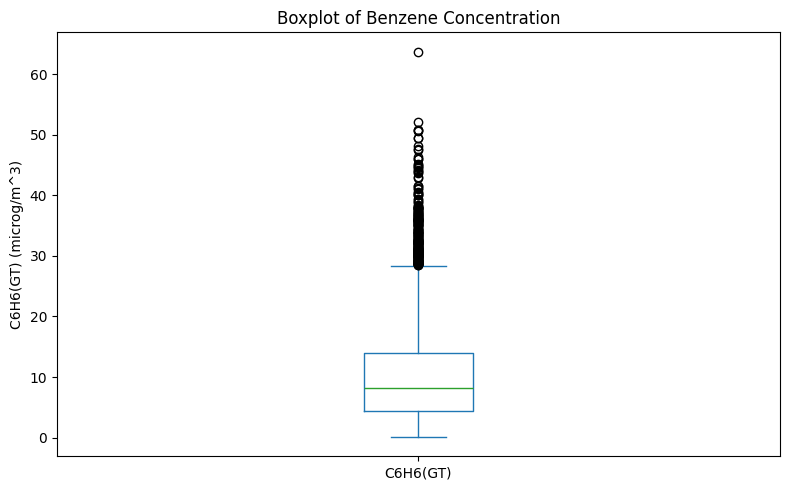

In [212]:
# boxplot of benzene concentration
plt.subplots(figsize=(8, 5))
benzene_analysis_df[target_col].plot.box()
plt.ylabel("C6H6(GT) (microg/m^3)")
plt.title("Boxplot of Benzene Concentration")
plt.tight_layout()
plt.show()